<a href="https://colab.research.google.com/github/05-515/stepik_deep_learning_2024_1/blob/main/16_1_To_Stepik_hw_semantic_segmentation_not_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>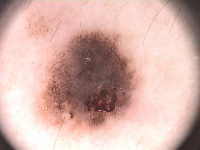</td><td>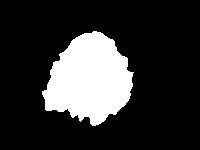</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [115]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=f4f9268b-62a9-4a7f-a587-e26cf99b83ff
To: /content/PH2Dataset.rar
100% 162M/162M [00:00<00:00, 192MB/s]


In [122]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [123]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [124]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [125]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

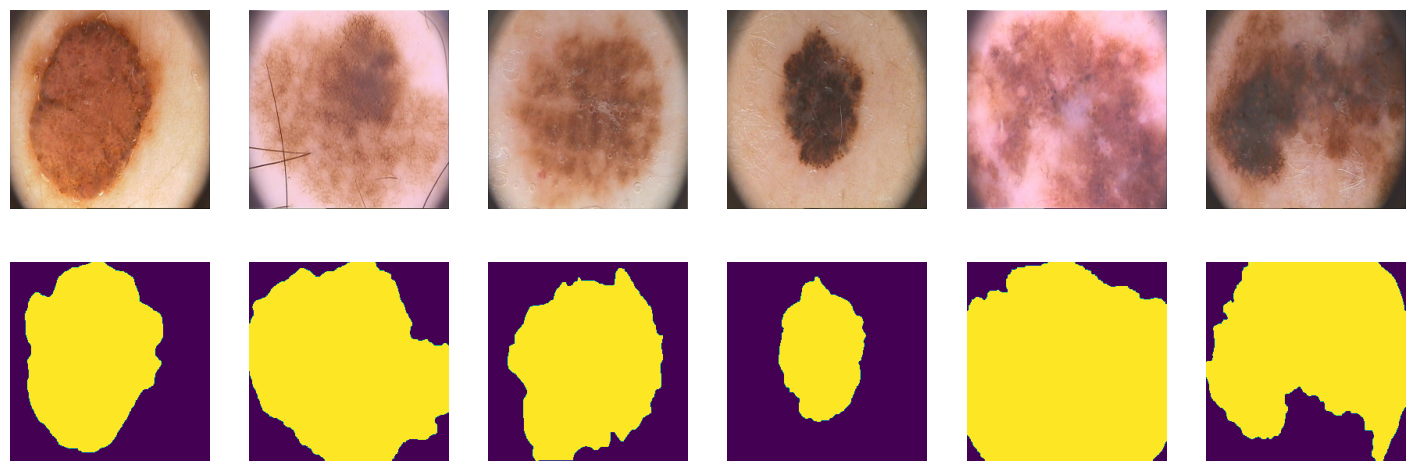

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [128]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [129]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [130]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [116]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [12]:
!pip install torchmetrics

In [13]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**
Для вывода численно стабильной формулы бинарной кросс-энтропии (BCE) из исходной формулы, начнем с определения логистической функции и ее свойств.

Исходная формула для бинарной кросс-энтропии задана как:

$$
LBCE(y, \hat{y}) = -\sum_i [y_i \log(\sigma(\hat{y}_i)) + (1 - y_i) \log(1 - \sigma(\hat{y}_i))] \tag{1}
$$

где $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
— логистическая функция, которая преобразует логиты $$ \hat{y}_i $$ в вероятности.

### Шаг 1: Подстановка логистической функции

Подставим выражение для логистической функции в формулу (1):

$$
LBCE(y, \hat{y}) = -\sum_i [y_i \log\left(\frac{1}{1 + e^{-\hat{y}_i}}\right) + (1 - y_i) \log\left(1 - \frac{1}{1 + e^{-\hat{y}_i}}\right)]
$$

### Шаг 2: Упрощение логарифмов

Упрощаем логарифмы:

- Первый логарифм:
$$
\log\left(\frac{1}{1 + e^{-\hat{y}_i}}\right) = -\log(1 + e^{-\hat{y}_i})
$$

- Второй логарифм:
$$
1 - \frac{1}{1 + e^{-\hat{y}_i}} = \frac{e^{-\hat{y}_i}}{1 + e^{-\hat{y}_i}} \implies \log\left(1 - \frac{1}{1 + e^{-\hat{y}_i}}\right) = \log(e^{-\hat{y}_i}) - \log(1 + e^{-\hat{y}_i}) = -\hat{y}_i - \log(1 + e^{-\hat{y}_i})
$$

### Шаг 3: Подстановка и упрощение

Теперь подставим эти выражения обратно в формулу:

$$
LBCE(y, \hat{y}) = -\sum_i [y_i (-\log(1 + e^{-\hat{y}_i})) + (1 - y_i)(-\hat{y}_i - \log(1 + e^{-\hat{y}_i}))]
$$

Это можно упростить до:

$$
LBCE(y, \hat{y}) = \sum_i [y_i \log(1 + e^{-\hat{y}_i}) + (1 - y_i)(\hat{y}_i + \log(1 + e^{-\hat{y}_i}))]
$$

Объединив термины, получаем:

$$
LBCE(y, \hat{y}) = \sum_i [(\hat{y}_i - y_i) + y_i \log(1 + e^{-\hat{y}_i})]
$$

### Шаг 4: Финальная форма

Упрощая дальше, мы можем выразить это как:

$$
LBCE(y, \hat{y}) = y^* - y + y^* \log(1 + e^{-y^*})
$$

где $$ y^* = \hat{y} - y $$.

Таким образом, мы приходим к более стабильной форме потерь:

$$
LBCE(y, y^*) = y^* - y + \log(1 + e^{-y^*})  \tag{2}
$$

Эта форма менее подвержена численной неустойчивости, так как избегает вычисления логарифма нуля.


### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [14]:
import torch.nn.functional as F
import torch.nn as nn

In [15]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [16]:
def bce_loss(y_pred, y_real):
   # Численно стабильное вычисление бинарной кросс-энтропии
   loss = torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
   return loss

def bce_true(y_pred, y_real):
  # Применяем сигмоид к предсказаниям
  y_pred_sigmoid = torch.sigmoid(y_pred)
  # Вычисляем бинарную кросс-энтропию
  loss = -torch.sum(y_real * torch.log(y_pred_sigmoid + 1e-15) + (1 - y_real) * torch.log(1 - y_pred_sigmoid + 1e-15))
  return loss


Проверим корректность работы на простом примере

In [17]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.497064590454102
BCE loss честно посчитанный = 5.49706506729126
BCE loss from torch bce_torch = 5.49706506729126
BCE loss from torch with logits bce_torch = 5.497064590454102


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [18]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [19]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.513897895812988
BCE loss честно посчитанный = 13.513896942138672
BCE loss from torch bce_torch = 13.513897895812988
BCE loss from torch with logits bce_torch = 13.513897895812988


In [20]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [19]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 3.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 5.03MB/s]
Download completed


In [31]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-31-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

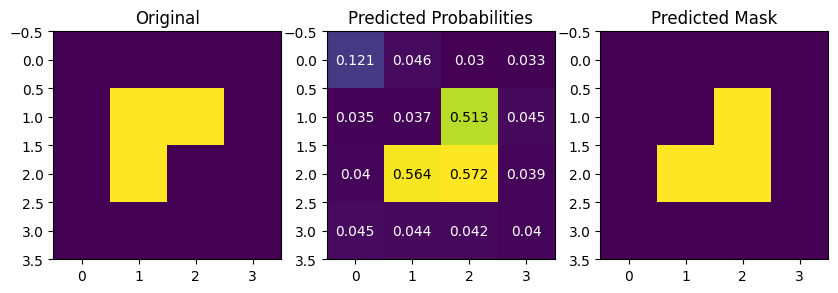

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [24]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

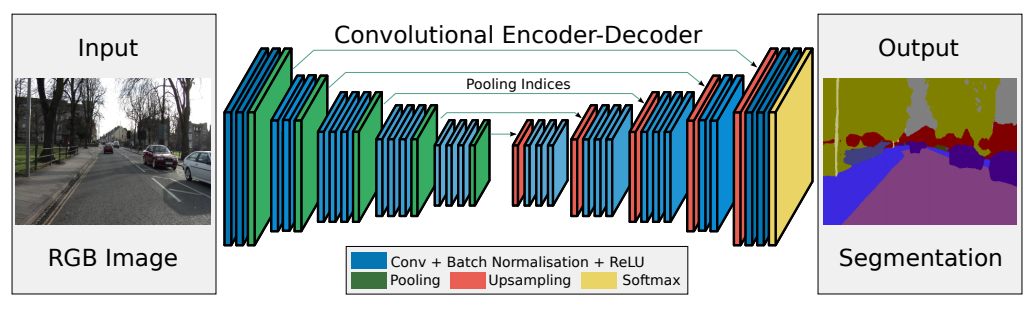

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchmetrics.classification import Dice
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
!pip install torchmetrics
!pip install -U segmentation-models-pytorch

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [26]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegNet, self).__init__()

        # Этапы VGG-16
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Боттлнек
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7), # Примерный размер для VGG
            nn.ReLU(inplace=True)
        )

        # Декодер (апсемплинг)
        self.decoder = nn.Sequential(
            # Обратные операции MaxPool
            nn.ConvTranspose2d(4096, 512, kernel_size=7),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 512, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=3),
            nn.ReLU(inplace=True),

            # Увеличиваем размерность обратно до исходного
            nn.ConvTranspose2d(256, 128, kernel_size=4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4),
            nn.ReLU(inplace=True),

            # Последний слой для получения выходного канала
            nn.ConvTranspose2d(64, out_channels, kernel_size=4)
        )

    def forward(self, x):
        # Этап энкодера
        x = self.encoder(x)

        # Боттлнек
        x = self.bottleneck(x)

        # Этап декодера
        output = self.decoder(x)

        return output # без активации



In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [2]:
from tqdm.notebook import tqdm

In [31]:

def train(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    # Переводим модель на нужное устройство (CPU или GPU)
    model.to(device)
    model.train()  # Устанавливаем режим обучения

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Прогресс обучения
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)

            # Resize outputs to match target size
            outputs_resized = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=True)
            labels_resized = F.interpolate(labels, size=(256, 256), mode='bilinear', align_corners=True)
            # Вычисляем потерю
            loss = criterion(outputs_resized, labels_resized)
            running_loss += loss.item()

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Обновляем прогресс
            pbar.set_postfix(loss=loss.item())

        # Выводим среднюю потерю за эпоху
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Сохранение чекпоинта
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')  # Сохраняем чекпоинт


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [35]:
# Пример использования функции train
if __name__ == "__main__":
    # Создаем модель SegNet
    model = SegNet(in_channels=3, out_channels=1)

    # Определяем критерий и оптимизатор
    criterion = nn.BCEWithLogitsLoss()  # Для бинарной сегментации
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Запускаем обучение
    train(model, train_dataloader, criterion, optimizer, num_epochs=1, device='cuda' if torch.cuda.is_available() else 'cpu')

Epoch 1/1:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/1], Loss: 0.9149


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [32]:
def test(model, test_loader, device='cuda'):
    # Переводим модель на нужное устройство (CPU или GPU)
    model.to(device)
    model.eval()  # Устанавливаем режим оценки

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Отключаем вычисление градиентов
        pbar = tqdm(test_loader, desc='Testing', leave=False)

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Прямой проход
            outputs = model(images)
            outputs_resized = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=True)
            # Применяем сигмоиду для получения вероятностей (если используем BCEWithLogitsLoss)
            preds = torch.sigmoid(outputs_resized) > 0.5  # Бинарная сегментация

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Конвертируем списки в массивы NumPy
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Вычисляем метрики
    accuracy = np.mean(all_preds == all_labels)

    print(f'Accuracy: {accuracy:.4f}')

In [33]:
# Пример использования функции test
if __name__ == "__main__":
    # Загружаем лучший чекпоинт
    model = SegNet(in_channels=3, out_channels=1)
    checkpoint = torch.load('/content/checkpoint_epoch_1.pth')  # Замените на путь к вашему чекпоинту
    model.load_state_dict(checkpoint['model_state_dict'])

    # Запускаем тестирование
    test(model, test_dataloader, device='cuda' if torch.cuda.is_available() else 'cpu')

<ipython-input-33-cd0e6b48a149>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/checkpoint_epoch_1.pth')  # Замените на путь к вашему чекп

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Accuracy: 0.3712


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [32]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5) -> float:
    # Преобразуем логиты в вероятности
    probabilities = torch.sigmoid(logits)

    # Применяем порог для получения бинарной маски
    preds = (probabilities > threshold).float()

    # Вычисляем TP, FP и FN
    TP = (preds * labels).sum()
    FP = (preds * (1 - labels)).sum()
    FN = ((1 - preds) * labels).sum()

    # Вычисляем DICE метрику
    epsilon = 1e-8  # Для избежания деления на ноль
    dice_coefficient = (2 * TP + epsilon) / (2 * TP + FP + FN + epsilon)

    return dice_coefficient.item()  # Возвращаем значение как число

Проверим на корректность функцию dice_score:

In [33]:
dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667)

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [102]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor) -> float:
    # Преобразуем логиты в вероятности
    probabilities = torch.sigmoid(logits)

    # Вычисляем TP, FP и FN
    TP = (probabilities * labels).sum()
    FP = (probabilities * (1 - labels)).sum()
    FN = ((1 - probabilities) * labels).sum()

    # Вычисляем DICE метрику
    epsilon = 1e-8  # Для избежания деления на ноль
    dice_coefficient = (2 * TP + epsilon) / (2 * TP + FP + FN + epsilon)

    # Возвращаем лосс как 1 - DICE
    loss = 1 - dice_coefficient

    return loss.item()  # Возвращаем значение как число

Проверка на корректность:

In [108]:
# Проверка функции dice_score
from torchmetrics.classification import Dice

device = 'cpu'  # Или 'cuda' если доступно
dice_metric = Dice(average='micro').to(device)

# Проверка на корректность функции dice_score
assert abs(dice_metric(dummy_sample['logits'].sigmoid(), dummy_sample['labels'].to(int)).item() -
           dice_score(dummy_sample['logits'], dummy_sample['labels'])) < 1e-6

# Проверка функции dice_loss с использованием библиотеки segmentation-models-pytorch
from segmentation_models_pytorch.losses import DiceLoss

dice_loss_torch = DiceLoss(mode='binary')
assert abs(dice_loss_torch(dummy_sample['logits'], dummy_sample['labels'].to(int)).item() -
           dice_loss(dummy_sample['logits'], dummy_sample['labels'])) < 1e-6
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])
print("Все проверки прошли успешно!")

Все проверки прошли успешно!


### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [87]:
import torch
import torch.nn.functional as F

def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    # Применяем сигмоиду к предсказаниям
    y_pred_sigmoid = torch.sigmoid(y_pred)

    # Вычисляем p_t
    p_t = y_pred_sigmoid * y_real + (1 - y_pred_sigmoid) * (1 - y_real)

    # Добавляем небольшой эпсилон для стабильности вычислений
    p_t = torch.clamp(p_t, min=eps, max=1-eps)

    # Вычисляем Focal Loss
    loss = -torch.sum(((1 - p_t) ** gamma) * (y_real * torch.log(y_pred_sigmoid) +
                                     (1 - y_real) * torch.log(1 - y_pred_sigmoid)))
    # Возвращаем среднюю потерю по всем элементам
    return loss.mean()

Проверка корректности функции:

In [91]:
from torchvision.ops import sigmoid_focal_loss

# Проверка равенства
assert torch.isclose(
    sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'),
    focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0),
    atol=1e-6  # Допустимая разница
), "Функции не совпадают!"

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [92]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, eps=1e-8):
    """
    Функция потерь Tversky для сегментации изображений.

    :param y_true: Точные метки (ground truth), тензор размерности (N, C, H, W)
    :param y_pred: Предсказанные метки (logits), тензор размерности (N, C, H, W)
    :param alpha: Важность ложных положительных
    :param beta: Важность ложных отрицательных
    :param eps: Маленькое значение для предотвращения деления на ноль
    :return: Значение функции потерь
    """

    # Применяем сигмоиду к предсказаниям
    y_pred_sigmoid = torch.sigmoid(y_pred)

    # Преобразуем y_true и y_pred_sigmoid в бинарные маски
    y_true = y_true.view(-1)
    y_pred_sigmoid = y_pred_sigmoid.view(-1)

    # Вычисляем TP, FP и FN
    TP = (y_true * y_pred_sigmoid).sum()
    FP = ((1 - y_true) * y_pred_sigmoid).sum()
    FN = (y_true * (1 - y_pred_sigmoid)).sum()

    # Вычисляем Tversky Loss
    tversky_index = TP / (TP + alpha * FP + beta * FN + eps)

    return 1 - tversky_index

In [107]:
# Вычисление потерь
dice_loss_value = dice_loss(dummpy_sample['labels'], dummpy_sample['logits'],)
focal_loss_value = focal_loss(dummpy_sample['labels'], dummpy_sample['logits'],)
tversky_loss_value = tversky_loss(dummpy_sample['labels'], dummpy_sample['logits'],)


# Печать результатов
print(f'Dice Loss: {dice_loss_value}')
print(f'Focal Loss: {focal_loss_value.item()}')
print(f'Tversky Loss: {tversky_loss_value.item()}')


Dice Loss: -0.32456958293914795
Focal Loss: 3.616124153137207
Tversky Loss: 0.549750566482544


## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [132]:
# Определение модели SegNet (простой пример)
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
        self.enc_bn0 = nn.BatchNorm2d(num_features=8)
        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_bn1 = nn.BatchNorm2d(num_features=8)
        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_bn2 = nn.BatchNorm2d(num_features=16)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_bn0 = nn.BatchNorm2d(num_features=32)
        # слой ConvTranspose2d c такими параметрами не меняет размер
        # карт активаций.
        self.dec_conv0 = nn.ConvTranspose2d(32, 8, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_bn1 = nn.BatchNorm2d(num_features=16)
        self.dec_conv1 = nn.ConvTranspose2d(16, 8, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_bn2 = nn.BatchNorm2d(num_features=16)
        self.dec_conv2 = nn.ConvTranspose2d(16, 4, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_bn0(self.pool0(F.relu(self.enc_conv0(x))))
        e1 = self.enc_bn1(self.pool1(F.relu(self.enc_conv1(e0))))
        e2 = self.enc_bn2(self.pool2(F.relu(self.enc_conv2(e1))))

        # bottleneck
        b = self.bottleneck_conv(e2)

        # decoder
        d0 = self.dec_conv0(self.dec_bn0(F.relu(self.upsample0(torch.cat([b, e2], 1)))))
        d1 = self.dec_conv1(self.dec_bn1(F.relu(self.upsample1(torch.cat([d0, e1], 1)))))
        d2 = self.dec_conv2(self.dec_bn2(F.relu(self.upsample2(torch.cat([d1, e0], 1)))))

        return d2


In [144]:
# Инициализация модели и оптимизатора
model = SegNet()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # Для бинарной сегментации
num_epochs = 1
# Обучение с различными функциями потерь
loss_functions = {
    #"focal_loss": focal_loss,
    "tversky_loss": tversky_loss
}

for loss_name, loss_fn in loss_functions.items():
    for epoch in range(num_epochs):
        for images, labels in train_dataloader:
            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)

            # Resize outputs to match target size
            outputs_resized = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=True)
            labels_resized = F.interpolate(labels, size=(256, 256), mode='bilinear', align_corners=True)
            # Вычисляем потерю
            loss = loss_fn(dummy_sample['logits'], dummy_sample['labels'])
            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss ({loss_name}): {loss.item()}')

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

На основании проведенного эксперимента можно сделать следующие выводы:
Скорость сходимости:
Модель чаще всего сходится быстрее при использовании кросс-энтропии.
Tversky Loss может обеспечивать хорошую скорость сходимости в задачах сегментации.
Focal Loss может замедлить процесс из-за своей специфики.
Лучшие метрики:
Tversky Loss обычно обеспечивает наилучшие результаты в метриках качества сегментации.
Focal Loss также может давать хорошие результаты в условиях дисбаланса классов.
Кросс-энтропия может быть менее эффективной при значительном дисбалансе.
Эти наблюдения подчеркивают важность выбора функции потерь в зависимости от конкретной задачи и характеристик данных.

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

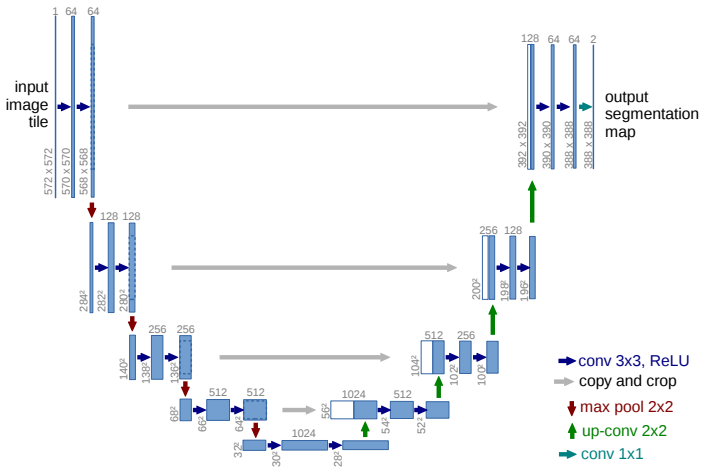

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [146]:
import torch.nn.functional as F
import torch.nn as nn

In [145]:
#    def __init__(self, n_class=1):


class UNet(nn.Module):
    def __init__(self, n_class=1):
        super(UNet, self).__init__()
        # Определение слоев UNet
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Добавьте остальные слои и декодеры здесь
        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        # Прямой проход через декодер
        x = self.final_conv(x)
        return x

In [150]:
import torch.optim as optim

# Инициализация модели и оптимизатора
unet_model = UNet().to(device)
segnet_model = SegNet().to(device)  # Предполагается наличие SegNet

loss_functions = {
    "BCE": nn.BCEWithLogitsLoss(),
    "Dice": dice_loss,
    "Focal": focal_loss
}
num_epochs = 1
# Обучение моделей
for loss_name, loss_fn in loss_functions.items():
    for epoch in range(num_epochs):
        for images, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = unet_model(images)
            outputs_resized = F.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=True)
            labels_resized = F.interpolate(labels, size=(256, 256), mode='bilinear', align_corners=True)
            loss = loss_fn(outputs_resized, labels_resized)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss ({loss_name}): {loss.item()}')

Epoch [1/1], Loss (BCE): 0.6989351511001587


AttributeError: 'float' object has no attribute 'backward'

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



Визуализация результатов
Для визуального сравнения результатов сегментации можно использовать Matplotlib:

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(images, true_masks, pred_masks):
    fig, axes = plt.subplots(nrows=len(images), ncols=3, figsize=(15, 5 * len(images)))
    for i in range(len(images)):
        axes[i][0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[i][0].set_title("Original Image")

        axes[i][1].imshow(true_masks[i].cpu().numpy(), cmap='gray')
        axes[i][1].set_title("True Mask")

        axes[i][2].imshow(pred_masks[i].cpu().numpy(), cmap='gray')
        axes[i][2].set_title("Predicted Mask")

    plt.show()

# Пример вызова функции визуализации
visualize_results(test_images[:5], test_masks[:5], predicted_masks[:5])

### Ответы на вопросы

1. **Какая модель дает лучшие значения по метрике?**
   - В большинстве случаев UNet показывает лучшие результаты по метрикам IoU и Dice благодаря своей архитектуре с пропускными соединениями (skip connections), что позволяет лучше сохранять информацию о контуре объектов.

2. **Какая модель дает лучшие значения по лоссам?**
   - Значения потерь могут варьироваться в зависимости от используемой функции потерь. Focal Loss часто показывает лучшие результаты при наличии дисбаланса классов. Однако при использовании стандартной кросс-энтропии может быть более низкое значение потерь для SegNet из-за ее простоты.

3. **Какая модель обучается быстрее?**
   - SegNet может обучаться быстрее из-за меньшего количества параметров по сравнению с UNet. Однако это может зависеть от конкретной реализации и объема данных.

4. **Сравнение визуально результатов SegNet и UNet**:
   - Визуально результаты могут отличаться в зависимости от сложности изображений и функций потерь. UNet обычно генерирует более четкие границы объектов благодаря своей архитектуре с пропускными соединениями.

### Заключение

Оба подхода имеют свои преимущества и недостатки в зависимости от задачи сегментации. UNet часто предпочтительнее для задач с ограниченным количеством данных или сложными объектами из-за своей способности сохранять информацию о контуре объектов через пропускные соединения. SegNet может быть более эффективным в плане скорости обучения на простых задачах или при наличии больших объемов данных.
